# PRÉPARATION DONNÉES CIN_Recto

## Imports et Configuration

### Imports

In [1]:
import fitz  # PyMuPDF
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shutil
from sklearn.model_selection import train_test_split
import os

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### Creation des dossiers et Configuration des chemins

In [2]:
BASE_DIR = Path("..") / "data"
RAW_DIR = BASE_DIR / "raw" / "cin_recto"
PROCESSED_DIR = BASE_DIR / "processed" / "cin_recto"
ORIGINAL_DIR = PROCESSED_DIR / "original"
AUGMENTED_DIR = PROCESSED_DIR / "augmented"
FINAL_DIR = BASE_DIR / "final" / "cin_recto"

for d in [RAW_DIR, PROCESSED_DIR, ORIGINAL_DIR, AUGMENTED_DIR, FINAL_DIR]:
    os.makedirs(d, exist_ok=True)

In [3]:
# Lister les images (jpg/jpeg/png)
image_exts = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
raw_images = []
for ext in image_exts:
    raw_images.extend(RAW_DIR.glob(ext))
raw_images = sorted(raw_images)

print(f"{len(raw_images)} images CIN recto trouvées dans {RAW_DIR}:")

36 images CIN recto trouvées dans ../data/raw/cin_recto:


## Normalisation des images brutes

In [4]:
TARGET_MAX_SIZE = 800  # côté max (pixels), pour normaliser un peu sans perdre trop de détails

def normalize_cin_image(input_path, output_path):
    img = Image.open(input_path).convert("RGB")  # on garde couleur ici
    w, h = img.size

    # Redimensionnement en gardant le ratio, max(TARGET_MAX_SIZE)
    scale = TARGET_MAX_SIZE / max(w, h)
    if scale < 1.0:
        new_w, new_h = int(w * scale), int(h * scale)
        img = img.resize((new_w, new_h), Image.LANCZOS)

    img.save(output_path, format="PNG")


In [5]:
# Normaliser toutes les images vers ORIGINAL_DIR
normalized_paths = []
for img_path in tqdm(raw_images, desc="Normalisation"):
    out_name = f"{img_path.stem}.png"
    out_path = ORIGINAL_DIR / out_name
    normalize_cin_image(img_path, out_path)
    normalized_paths.append(out_path)

print(f"{len(normalized_paths)} images normalisées dans {ORIGINAL_DIR}")

Normalisation: 100%|██████████| 36/36 [00:06<00:00,  5.88it/s]

36 images normalisées dans ../data/processed/cin_recto/original


## Augmentation des images

### Classe qui contient les techniques d'augmentation

In [6]:
class ImageAugmentor:
    """Classe pour augmenter les images de factures"""
    
    def __init__(self, seed=42):
        self.seed = seed
        random.seed(seed)
    
    def rotate(self, image, angle_range=(-10, 10)):
        """Rotation aléatoire (scan non parfait)"""
        angle = random.uniform(*angle_range)
        return image.rotate(angle, fillcolor='white', expand=False)
    
    def add_noise(self, image, intensity=0.02):
        """Ajout de bruit gaussien (qualité scan/photo)"""
        img_array = np.array(image).astype(np.float32)
        noise = np.random.normal(0, intensity * 255, img_array.shape)
        noisy_img = np.clip(img_array + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(noisy_img)
    
    def adjust_brightness(self, image, factor_range=(0.8, 1.2)):
        """Ajustement luminosité (conditions éclairage)"""
        factor = random.uniform(*factor_range)
        enhancer = ImageEnhance.Brightness(image)
        return enhancer.enhance(factor)
    
    def adjust_contrast(self, image, factor_range=(0.8, 1.2)):
        """Ajustement contraste (qualité impression)"""
        factor = random.uniform(*factor_range)
        enhancer = ImageEnhance.Contrast(image)
        return enhancer.enhance(factor)
    
    def add_blur(self, image, radius_range=(0.5, 2.0)):
        """Ajout de flou (photo non nette)"""
        radius = random.uniform(*radius_range)
        return image.filter(ImageFilter.GaussianBlur(radius))
    
    
    def perspective_transform(self, image, intensity=0.1):
        """Transformation perspective (photo smartphone)"""
        img_array = np.array(image)
        h, w = img_array.shape[:2]
        
        # Points source (coins de l'image)
        src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
        
        # Points destination (légèrement déformés)
        offset = int(min(h, w) * intensity)
        dst_points = np.float32([
            [random.randint(0, offset), random.randint(0, offset)],
            [w - random.randint(0, offset), random.randint(0, offset)],
            [w - random.randint(0, offset), h - random.randint(0, offset)],
            [random.randint(0, offset), h - random.randint(0, offset)]
        ])
        
        # Appliquer transformation
        matrix = cv2.getPerspectiveTransform(src_points, dst_points)
        warped = cv2.warpPerspective(img_array, matrix, (w, h), 
                                      borderMode=cv2.BORDER_CONSTANT,
                                      borderValue=(255, 255, 255))
        return Image.fromarray(warped)
    
    def augment_pipeline(self, image, num_transforms=3):
        """
        Pipeline complet d'augmentation avec transformations aléatoires
        
        Args:
            image: Image PIL
            num_transforms: Nombre de transformations à appliquer
        """
        transforms = [
            self.rotate,
            self.add_noise,
            self.adjust_brightness,
            self.adjust_contrast,
            self.add_blur,
            self.perspective_transform
        ]
        
        # Sélectionner aléatoirement num_transforms
        selected = random.sample(transforms, min(num_transforms, len(transforms)))
        
        augmented = image.copy()
        for transform in selected:
            augmented = transform(augmented)
        
        return augmented


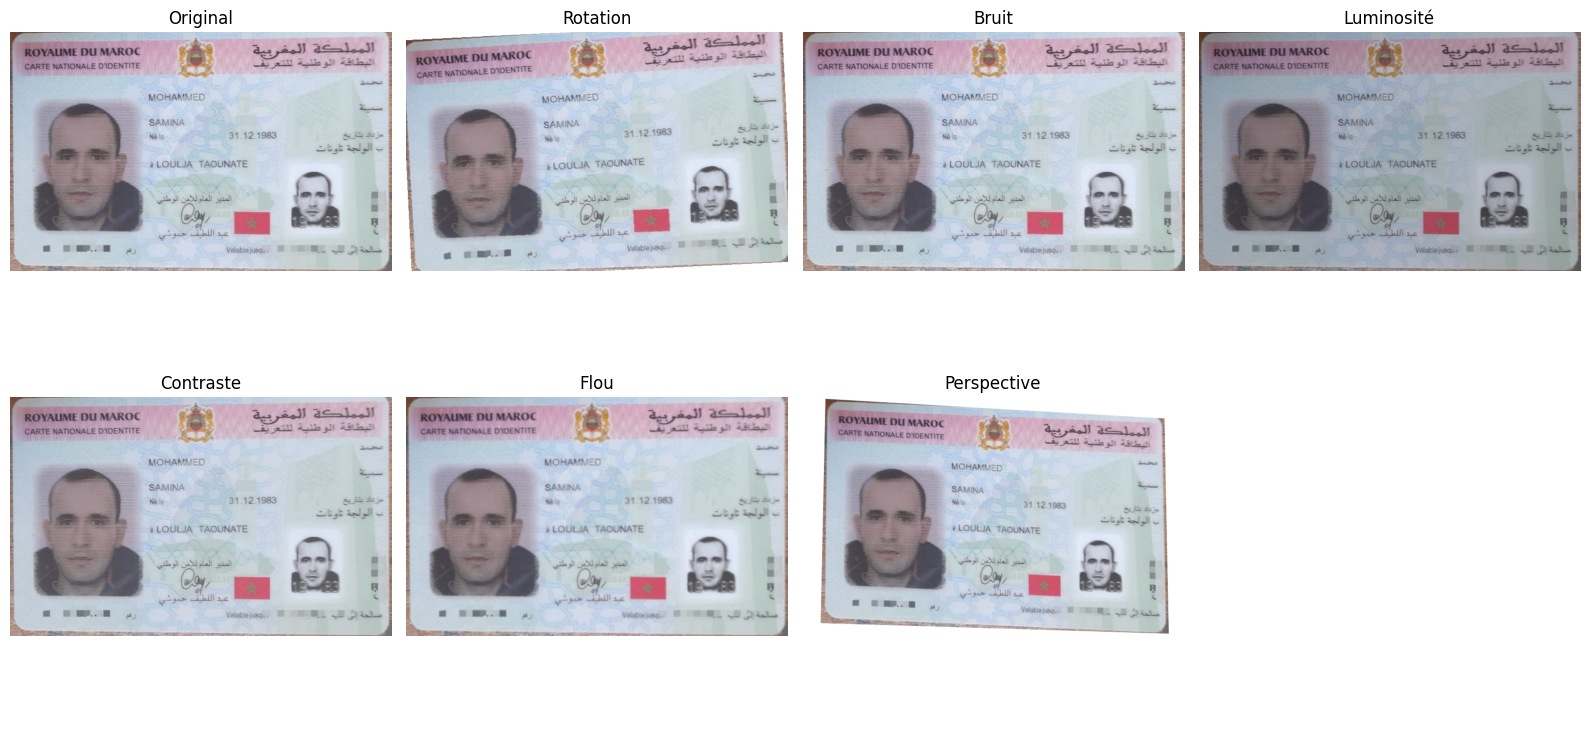

In [7]:
# Récupérer une image de test
test_images = sorted(ORIGINAL_DIR.glob("*.png"))

test_img_path = test_images[0]
test_img = Image.open(test_img_path).convert("RGB")

augmentor = ImageAugmentor(seed=SEED)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Image originale
axes[0].imshow(test_img)
axes[0].set_title("Original")
axes[0].axis("off")

# Différentes augmentations
aug_methods = [
    ("Rotation",      lambda img: augmentor.rotate(img)),
    ("Bruit",         lambda img: augmentor.add_noise(img)),
    ("Luminosité",    lambda img: augmentor.adjust_brightness(img)),
    ("Contraste",     lambda img: augmentor.adjust_contrast(img)),
    ("Flou",          lambda img: augmentor.add_blur(img)),
    ("Perspective",   lambda img: augmentor.perspective_transform(img)),
]

for i, (name, method) in enumerate(aug_methods, 1):
    if i >= len(axes):
        break
    aug_img = method(test_img)
    axes[i].imshow(aug_img)
    axes[i].set_title(name)
    axes[i].axis("off")

# Masquer les axes restants s'il y en a
for j in range(len(aug_methods) + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### Génération du Dataset Augmenté

In [8]:
# Configuration augmentation
NUM_AUGMENTATIONS_PER_IMAGE = 3  # 3x par image (ratio conservateur)
NUM_TRANSFORMS_PER_AUG = 3        # 3 transformations aléatoires par image

augmentor = ImageAugmentor(seed=SEED)

for img_path in tqdm(ORIGINAL_DIR.glob("*.png"), desc="Augmentation"):
    img = Image.open(img_path).convert('RGB')
    base_name = img_path.stem
    
    # Générer augmentations
    for i in range(NUM_AUGMENTATIONS_PER_IMAGE):
        augmented = augmentor.augment_pipeline(img, num_transforms=NUM_TRANSFORMS_PER_AUG)
        
        # Sauvegarder
        output_path = AUGMENTED_DIR / f"{base_name}_aug_{i+1:03d}.png"
        augmented.save(output_path)


Augmentation: 36it [00:16,  2.16it/s]


### Nombre totale des images

In [9]:
all_images = list(ORIGINAL_DIR.glob("*.png")) + list(AUGMENTED_DIR.glob("*.png"))

print(f"Total: {len(all_images)}")


Total: 144


## Split data

In [10]:
# Split stratifié: 70% train, 15% val, 15% test
train_images, temp_images = train_test_split(
    all_images, 
    test_size=0.3, 
    random_state=SEED
)

val_images, test_images = train_test_split(
    temp_images, 
    test_size=0.5, 
    random_state=SEED
)


print(f"Train: {len(train_images)}")
print(f"Val:   {len(val_images)}")
print(f"Test:  {len(test_images)}")

# Copier dans les dossiers finaux
splits = {
    'train': train_images,
    'val': val_images,
    'test': test_images
}

for split_name, images in splits.items():
    split_dir = FINAL_DIR / split_name
    split_dir.mkdir(parents=True, exist_ok=True)
    
    for img_path in tqdm(images, desc=f"Copie {split_name}"):
        shutil.copy2(img_path, split_dir / img_path.name)


Train: 100
Val:   22
Test:  22


Copie test: 100%|██████████| 22/22 [00:00<00:00, 1404.91it/s]
